# **Actividad de aprendizaje profundo**
## Realizado por: Juan José Restrepo Rosero
---
Finalmente, de manera individual tomaremos como base el script que encontraremos a continuación:

[Actividad: Redes Neuronales](https://auladigital.javerianacali.edu.co/content/enforced/255029-GRAD;400ITA019;A;20251/2024/Script2M1U1.ipynb?ou=255029)

El script debe cumplir los siguientes criterios:

1. Construir una red neuronal utilizando la API funcional de Keras. para acceder al enlace, haz clic [aquí.](https://www.tensorflow.org/guide/keras/functional?hl=es-419)
2. El parámetro batch_size se debe fijar como el número de instancias en el conjunto de entrenamiento.
3. Debe realizarse una búsqueda de algunos hiperparámetros, número de capas, número de unidades por cada y funciones de activación, de tal forma que se maximice el accuracy sobre el conjunto de prueba (el accuracy debe ser superior al 78%).
4. Luego de completar el numeral anterior, añada una nueva sección en el código, allí se debe tomar el mejor modelo del numeral 3 y entrenarlo con diferentes valores para el parámetro “learning rate”, específicamente analizar el comportamiento del modelo para los siguientes valores: 0.0001, 0.01, 0.1, 1, 10. Para cada uno de los experimentos obtenga las gráficas de la función de costo y del accuracy para los conjuntos de entrenamiento y prueba (no realizar búsqueda de hiperparámetros). Con base en las gráficas concluya acerca del efecto del learning rate en el entrenamiento de una red neuronal.


### Introducción
En este notebook se exploran los fundamentos y la implementación práctica de redes neuronales utilizando la API funcional de ***Keras***.

A través de la experimentación estructurada, se realiza el diseño, entrenamiento y evaluación de una red sobre el conjunto de datos ***Fashion-MNIST***.
Se busca alcanzar una precisión superior al $78$% en el conjunto de prueba mediante búsqueda de hiperparámetros y analizar el impacto del parámetro de aprendizaje (`learning rate`) sobre la convergencia y desempeño del modelo.


## **Etapa 1: Carga de los datos.**

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para esta actividad, usaremos la base de datos Fashion-MNIST, la cual consiste en identificar tipos de prendas de vestir https://keras.io/api/datasets/fashion_mnist/. Esta base de datos configura un problema de 10 clases.

Se cargan las librerías necesarias

In [14]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.optimizers import Adam

Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Las imágenes tienen tamaño 28x28. A continuación de muestran algunos ejemplos.

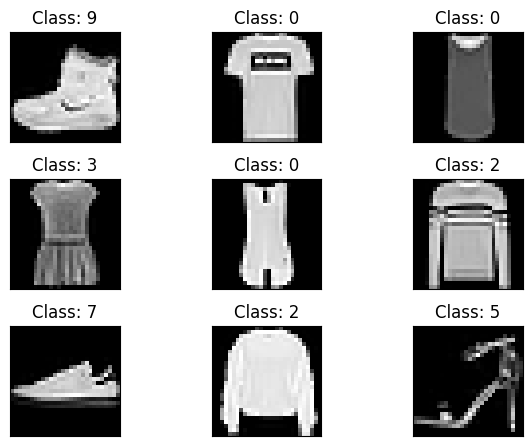

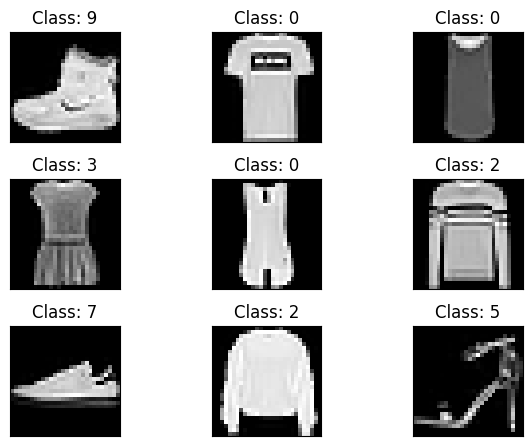

In [3]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Class: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [4]:
clases = np.unique(y_train)

num_clases = len(clases)
print('Numero total de clases: ', num_clases)
print('Tipos de clases: ', clases)

Numero total de clases:  10
Tipos de clases:  [0 1 2 3 4 5 6 7 8 9]


Como podemos observar, hay **10 diferentes tipos de clases** para cada prenda.

A continuación, pasamos a identificar el nombre de cada una por su label o etiqueta y a imprimir los 10 primeros elementos con su respectiva Clase/Label

In [5]:
nombres_clases = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
# Estos labels se obtuvieron de la documentación del dataset

# Tensorflow: https://www.tensorflow.org/datasets/catalog/fashion_mnist
# Github: https://github.com/zalandoresearch/fashion-mnist

for i in range(10):
    label = y_train[i]
    nombre_clase = nombres_clases[label]
    print(f"Label {label}: {nombre_clase}")

Label 9: Ankle boot
Label 0: T-shirt/top
Label 0: T-shirt/top
Label 3: Dress
Label 0: T-shirt/top
Label 2: Pullover
Label 7: Sneaker
Label 2: Pullover
Label 5: Sandal
Label 5: Sandal


## **Etapa 2: Preprocesamiento de datos**



Para preparar los datos antes de entrenar la red neuronal, se aplican dos transformaciones fundamentales:

#### **1. Normalización de imágenes**
Cada imagen del dataset Fashion-MNIST se representa originalmente como una matriz de $28\times28$ píxeles con valores enteros en el rango $[0, 255]$. La normalización consiste en escalar estos valores a un rango $[0, 1]$, lo que se logra dividiendo cada valor por 255.

- **Estabilidad Numérica:** Al trabajar con valores entre 0 y 1, se evitan problemas numéricos durante la propagación y se acelera la convergencia del optimizador.

- **Consistencia en la Escala:** Se adapta la entrada al rango esperado por la mayoría de las funciones de activación.

- **Optimización Eficiente:** Con valores normalizados, el descenso del gradiente se comporta de manera más predecible.


$$
x_{\text{norm}} = \frac{x}{255.0}
$$

donde $x$ es el tensor de entrada con dimensiones $(60.000, 28, 28)$ para el conjunto de entrenamiento y $(10.000, 28, 28)$ para el de prueba.


**Nota:** En este bloque se mantiene la estructura original $28\times28$. El *aplastamiento (flattening)* se realizará dentro del modelo, mediante una capa Flatten(), lo cual permite separar el preprocesamiento de la transformación de forma, facilitando la modularidad del diseño.


#### **2. Codificación One-Hot de etiquetas**

Transformamos las etiquetas categóricas $y \in \{0,1,\ldots,9\}$ (10 clases en Fashion-MNIST) en vectores binarios $\mathbf{y} \in \{0,1\}^{10}$ mediante:

$$
\mathbf{y}_i =
\begin{cases}
1 & \text{si } i = y \\
0 & \text{en otro caso}
\end{cases}
$$

**Ejemplos del dataset**:  
- `0: T-shirt/top` → $[1,0,0,0,0,0,0,0,0,0]$  
- `1: Trouser` → $[0,1,0,0,0,0,0,0,0,0]$  
- `3: Dress` → $[0,0,0,1,0,0,0,0,0,0]$



In [6]:
# Se normalizan las imágenes en el rango [0,1] y se convierte la codificación de las etiquetas al formato one-hot.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# No se aplana aquí; la transformación se realizará en la arquitectura del modelo.
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [7]:
# Conversión de etiquetas a formato one-hot
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [8]:
print("Conjunto datos de entrenamiento Normalizados (X_train)\n")
x_train

Conjunto datos de entrenamiento Normalizados (X_train)



array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [9]:
print("Conjunto datos de prueba Normalizados (X_test)\n")
x_test

Conjunto datos de prueba Normalizados (X_test)



array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## **Etapa 3: Construcción del Modelo Parametrizable**

A diferencia de la API secuencial, la API funcional permite una mayor flexibilidad para diseñar arquitecturas complejas y realizar conexiones no lineales entre capas.

La arquitectura propuesta consta de:
- Una capa de entrada con dimensiones (28,28)
- Una capa `Flatten` para convertir el input en un vector unidimensional
- Tres capas ocultas densas con activación ReLU y regularización mediante Dropout (30%)
- Una capa de salida softmax con 10 unidades para clasificación multiclase

In [10]:
def build_model(num_units1, num_units2, num_units3, activation, dropout_rate):

    # Construimos y compilamos un modelo de red neuronal fully-connected usando la API funcional de Keras.

    inputs = Input(shape=(28, 28))                        # Entrada: Imagen 28x28
    x = Flatten()(inputs)                                 # Aplanamiento: 28x28 -> 784
    x = Dense(num_units1, activation=activation)(x)       # Primera capa densa
    x = Dropout(dropout_rate)(x)                          # Regularización con Dropout
    x = Dense(num_units2, activation=activation)(x)       # Segunda capa densa
    x = Dropout(dropout_rate)(x)
    x = Dense(num_units3, activation=activation)(x)       # Tercera capa densa
    outputs = Dense(10, activation='softmax')(x)          # Capa de salida para 10 clases
    model = Model(inputs=inputs, outputs=outputs)
    # Se compila el modelo con el optimizador Adam (learning_rate se ajustará luego en experimentos)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### Búsqueda de Hiperparámetros con RandomizedSearchCV

- Se utiliza KerasClassifier para envolver el modelo y se definen los rangos de hiperparámetros a explorar.

- Se fija el batch_size igual al número total de instancias en el entrenamiento.

In [11]:
# Definición del clasificador
model_wrapper = KerasClassifier(
    model=build_model,
    epochs=10,
    batch_size=len(x_train),
    verbose=1
)


# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'model__num_units1': [128, 256],
    'model__num_units2': [64, 128],
    'model__num_units3': [32, 64],
    'model__activation': ['relu', 'tanh'],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [10, 20, 40]
}

In [12]:
# Configuración y ejecución de la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=model_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
random_search.fit(x_train, y_train_cat)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=60000, epochs=10, model=<function build_model at 0x7ec28fef3880>, verbose=0),
                   n_jobs=-1,
                   param_distributions={'epochs': [10, 20, 40],
                                        'model__activation': ['relu', 'tanh'],
                                        'model__dropout_rate': [0.2, 0.3],
                                        'model__num_units1': [128, 256],
                                        'model__num_units2': [64, 128],
                                        'model__num_units3': [32, 64]},
                   random_state=42)

In [20]:
# Extraer los mejores hiperparámetros obtenidos en la búsqueda
best_params = random_search.best_params_
best_units1 = best_params['model__num_units1']
best_units2 = best_params['model__num_units2']
best_units3 = best_params['model__num_units3']
best_activation = best_params['model__activation']
best_dropout = best_params['model__dropout_rate']
best_epochs = best_params['epochs']

# Imprimir los mejores hiperparámetros de forma ordenada
print("Mejores hiperparámetros:")
print(f"  - Número de unidades en la primera capa: {best_units1}")
print(f"  - Número de unidades en la segunda capa: {best_units2}")
print(f"  - Número de unidades en la tercera capa: {best_units3}")
print(f"  - Función de activación: {best_activation}")
print(f"  - Tasa de dropout: {best_dropout}")
print(f"  - Número de épocas: {best_epochs}")

# Imprimir la mejor precisión (accuracy)
print(f"\n - Mejor precisión (accuracy) obtenida: {random_search.best_score_:.4f}")

# Obtener el mejor estimador (modelo) de la búsqueda
best_model = random_search.best_estimator_

# Nota: El learning rate no se optimizó en esta búsqueda, por lo que se usa el valor por defecto
learning_rate_value = best_model.model_.optimizer.learning_rate.numpy()
print("\nLearning rate del mejor modelo (valor por defecto):", learning_rate_value)

Mejores hiperparámetros:
  - Número de unidades en la primera capa: 256
  - Número de unidades en la segunda capa: 128
  - Número de unidades en la tercera capa: 64
  - Función de activación: relu
  - Tasa de dropout: 0.3
  - Número de épocas: 40

 - Mejor precisión (accuracy) obtenida: 0.8106

Learning rate del mejor modelo (valor por defecto): 0.001


In [15]:
# ---------------------------------------------------
# 5. Función para Visualizar las Métricas de Entrenamiento
# ---------------------------------------------------
def plot_history(history, title_suffix=""):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Curva de Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title(f'Accuracy {title_suffix}')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Curva de Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title(f'Loss {title_suffix}')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

## **Etapa 4: Experimentos con diferentes valores de learning rate**


Entrenando con learning rate = 0.0001
Test Accuracy con lr=0.0001: 0.6392


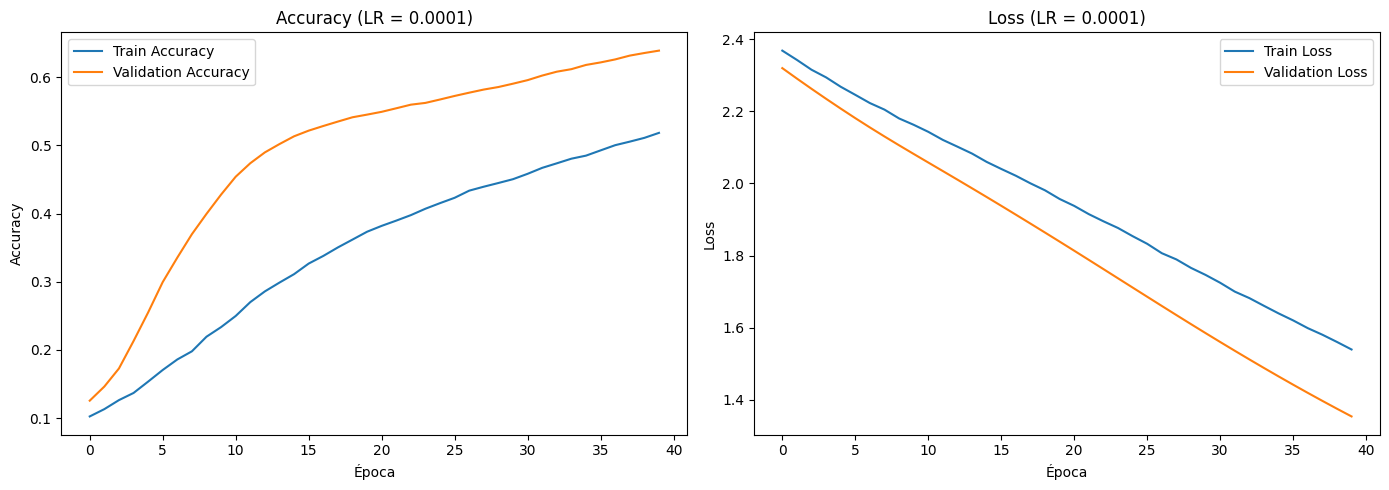


Entrenando con learning rate = 0.01
Test Accuracy con lr=0.01: 0.8222


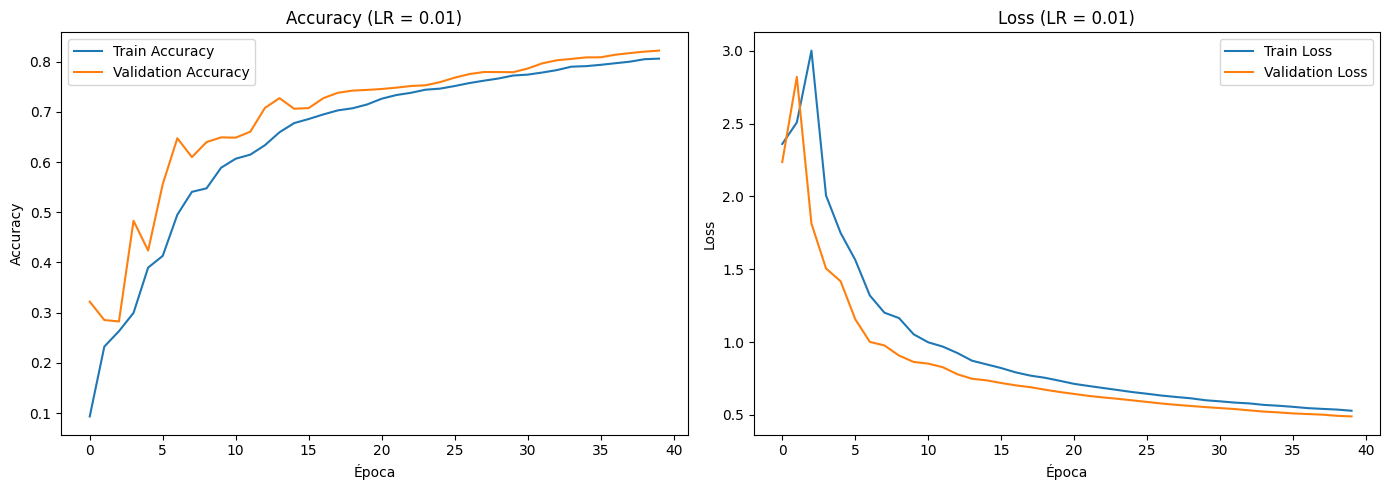


Entrenando con learning rate = 0.1
Test Accuracy con lr=0.1: 0.2800


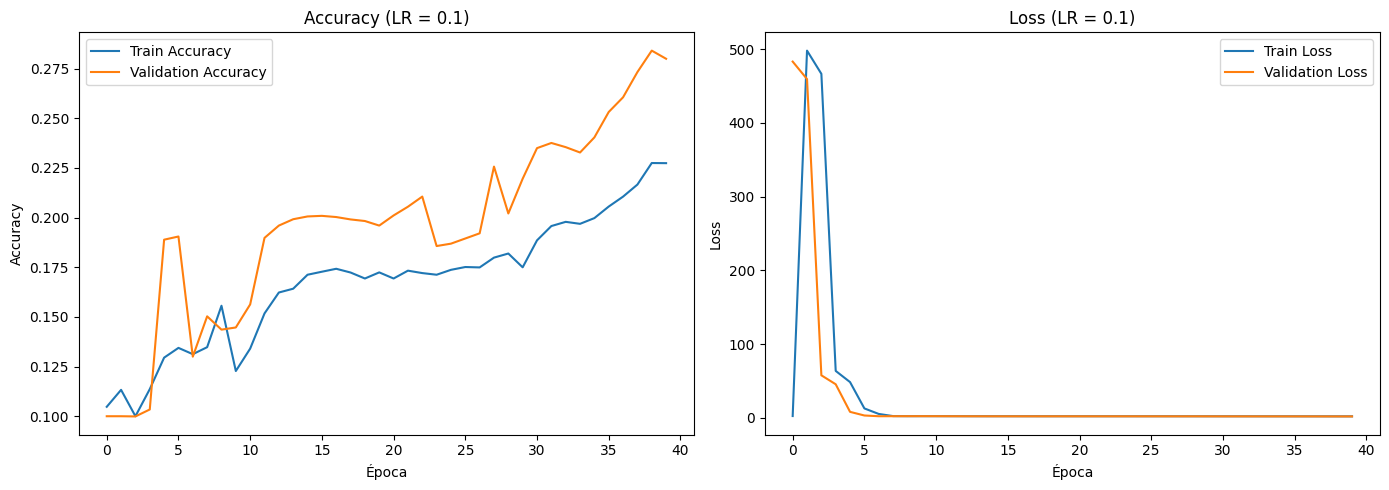


Entrenando con learning rate = 1.0
Test Accuracy con lr=1.0: 0.1000


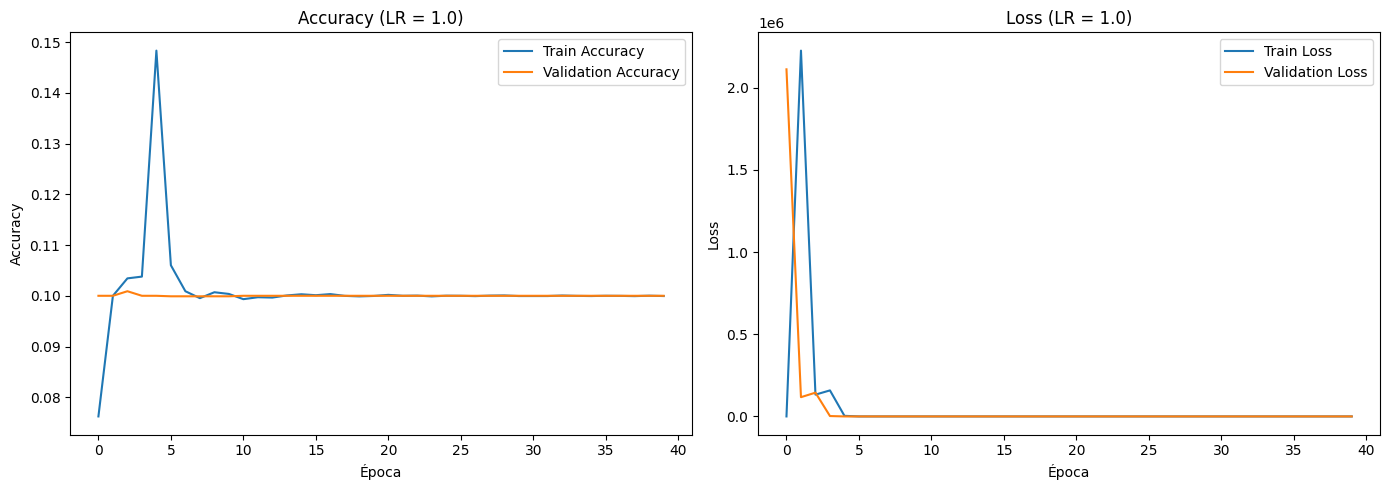


Entrenando con learning rate = 10.0
Test Accuracy con lr=10.0: 0.1000


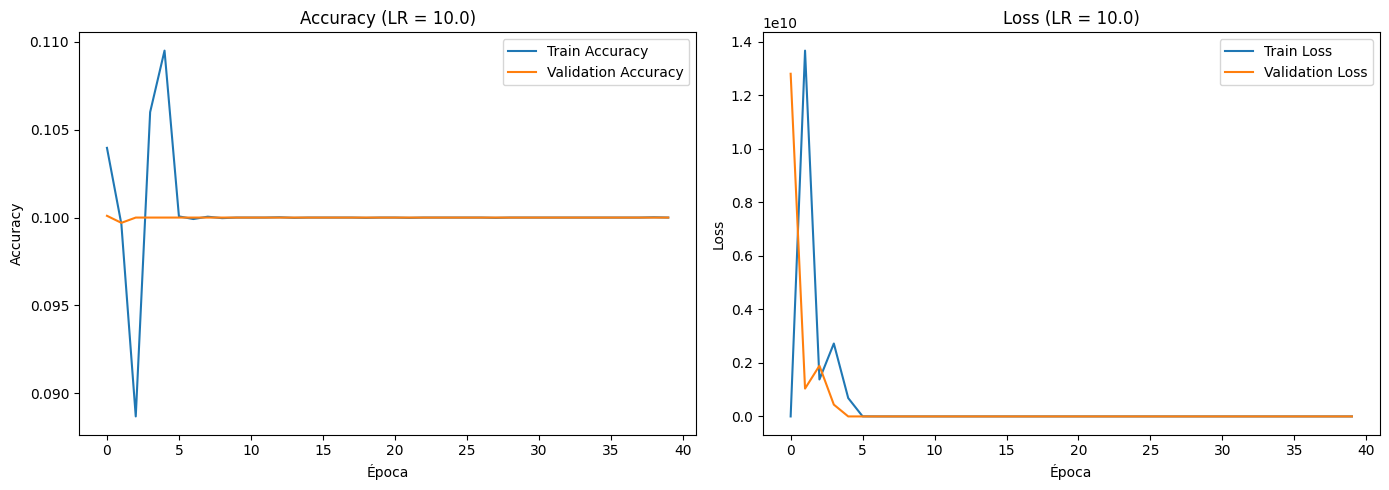

In [16]:
# Valores de learning rate a probar
learning_rates = [0.0001, 0.01, 0.1, 1.0, 10.0]

# Para almacenar los resultados de cada experimento
results = {}

for lr in learning_rates:
    print(f"\nEntrenando con learning rate = {lr}")
    # Construir el modelo con los mejores hiperparámetros
    model = build_model(
        num_units1=best_units1,
        num_units2=best_units2,
        num_units3=best_units3,
        activation=best_activation,
        dropout_rate=best_dropout
    )
    # Compilar el modelo con el learning rate especificado
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    # Entrenar el modelo usando batch_size igual al total de instancias
    history = model.fit(
        x_train, y_train_cat,
        validation_data=(x_test, y_test_cat),
        epochs=best_epochs,
        batch_size=len(x_train),
        verbose=0
    )

    # Evaluar el modelo sobre el conjunto de prueba
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"Test Accuracy con lr={lr}: {test_acc:.4f}")
    results[lr] = test_acc  # Almacenar el accuracy

    # Visualizar las métricas de entrenamiento
    plot_history(history, title_suffix=f"(LR = {lr})")



In [18]:
# Imprimir un resumen de los resultados de learning rate
print("\nResumen de Test Accuracy para distintos Learning Rates:")
for lr, acc in results.items():
    print(f"  - Learning Rate = {lr}: Test Accuracy = {acc:.4f}")


Resumen de Test Accuracy para distintos Learning Rates:
  - Learning Rate = 0.0001: Test Accuracy = 0.6392
  - Learning Rate = 0.01: Test Accuracy = 0.8222
  - Learning Rate = 0.1: Test Accuracy = 0.2800
  - Learning Rate = 1.0: Test Accuracy = 0.1000
  - Learning Rate = 10.0: Test Accuracy = 0.1000


# **Conclusiones**

## 1. Mejores Hiperparámetros Encontrados  
Tras una búsqueda aleatoria (*Randomized Search*), los valores óptimos fueron:  

- **Arquitectura de la red**:  
  - Capa 1: `256 neuronas`  
  - Capa 2: `128 neuronas`  
  - Capa 3: `64 neuronas`  
- **Función de activación**: `ReLU`  
- **Dropout**: `0.3`  
- **Épocas**: `40`
- **Accuracy**: `0.8106`  

**Observación**:  
La configuración combina profundidad para modelar relaciones complejas y regularización moderada (*dropout*) para evitar sobreajuste.

---
## 2. Comparación del Rendimiento por *Learning Rate*  

| **Learning Rate** | **Test Accuracy** | **Observación**                                                                 |
|--------------------|--------------------|---------------------------------------------------------------------------------|
| 0.0001             | 0.6392             | Convergencia lenta. Mejora constante pero no alcanza alta precisión.           |
| 0.01               | 0.8222             | **Mejor desempeño**. Equilibrio entre estabilidad y velocidad de convergencia. |
| 0.1                | 0.2800             | Red inestable. Pérdida cae abruptamente sin aprendizaje efectivo.              |
| 1.0                | 0.1000             | Explosión del gradiente. Modelo diverge.                                       |
| 10.0               | 0.1000             | Comportamiento errático. Colapso total desde el inicio.                        |

**Conclusión clave**:  
El *learning rate* de **0.01** maximiza la precisión sin comprometer estabilidad.


---

## 3. Análisis de Gráficas  

### 🟦 **Learning Rate = 0.0001**  
- **Accuracy**: Progresión lenta pero consistente. Validación supera entrenamiento (posible convergencia parcial).  
- **Loss**: Disminución continua y estable.  
- **Conclusión**: Aprendizaje seguro pero insuficiente. Ideal para entrenamientos largos.  

### 🟩 **Learning Rate = 0.01**  
- **Accuracy**: Mejora rápida en entrenamiento y validación. Curvas paralelas y suaves.  
- **Loss**: Disminución estable sin sobreajuste.  
- **Conclusión**: Parámetro óptimo. Balance ideal.  

### 🟥 **Learning Rate = 0.1**  
- **Accuracy**: Estancamiento en 28% (sin aprendizaje).  
- **Loss**: Caída abrupta seguida de estancamiento.  
- **Conclusión**: *Learning rate* puede ser un poco alto.  

### 🟧 **Learning Rate = 1.0**  
- **Accuracy**: Oscilaciones erráticas. Accuracy bajo, con valor del 10%.  
- **Loss**: Explosión inicial y colapso.  
- **Conclusión**: Explosión del gradiente.  

### 🟨 **Learning Rate = 10.0**  
- **Accuracy**: 10% (equivalente a predicción aleatoria).  
- **Loss**: Valores extremos sin recuperación.  
- **Conclusión**: Inutilizable.  





---

## 4. Síntesis General  
- **Hiperparámetro crítico**: *Learning rate* (determina éxito/fracaso del entrenamiento).  
- **Configuración óptima**:  
  - LR = 0.01  
  - Arquitectura de la Red: 256 → 128 → 64 + ReLU  
  - Dropout = 0.3  
- **Generalización**: La configuración es óptima, gracias a que existe una regularización y profundidad equilibrada.